# Visual Odometry based on Feature

In [51]:
# load libaray
import cv2
import os
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [88]:
import os
from tqdm import tqdm
path = './VO1_data/'
img_names = os.listdir(path)
img_names.sort()
images = []
for img_name in tqdm(img_names):
    img_path = path + img_name
    images.append(cv2.imread(img_path, flags=0))

100%|██████████| 52/52 [00:02<00:00, 24.89it/s]


## Step 1: Features Extraction

In [81]:
'''Find keypoints and descriptors for each image in the dataset'''
# images -- a list of grayscale images
# kp_list -- a list of keypoints for each image
# des_list -- a list of descriptors for each image
# kp -- a list of all "cv2.KeyPoint" objects for each image
# des -- numpy.ndarray
kp_list = []
des_list = []


for img in images:
    sift = cv2.SIFT_create(nfeatures=500)
    kp, des = sift.detectAndCompute(img, None)
    kp_list.append(kp)
    des_list.append(des)

## Step 2: Features Matching

In [82]:
'''Match features for each subsequent image pair in the dataset'''
# Each matches[i] is a list of matched features from images i and i + 1

# des_list -- a list of descriptors for each image in the dataset
# matches -- list of matches for each subsequent image pair in the dataset. 
# match --  a list of matched features from images i and i + 1
# match[i] -- cv2.DMatch: <DMatch .......> 


matches = []

for i in range(len(des_list) - 1):
    descriptor1 = des_list[i]
    descriptor2 = des_list[i + 1]

    
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50) 
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    match_2nn = flann.knnMatch(descriptor1, descriptor2, k=2)
    matches.append(match_2nn)

## Step 3: Matches Filtering

In [83]:
'''Filter matched features by threshold for each subsequent image pair in the dataset'''
# threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0)

threshold = 0.75
filtered_matches = []

for match_2nn in matches:

    filtered_match = []

    for m1, m2 in match_2nn:
        if m1.distance < threshold * m2.distance:
            filtered_match.append(m1)

    filtered_matches.append(filtered_match)

matches = filtered_matches

## Step 4: Trajetory Estimation

In [84]:
'''Estimate camera motion from a pair of subsequent image frames'''
# match -- list of matched features from the pair of images
# kp1 -- list of the keypoints in the first image
# kp2 -- list of the keypoints in the second image
# k -- camera calibration matrix 
# rmat -- recovered 3x3 rotation numpy matrix
# tvec -- recovered 3x1 translation numpy vector
# image1_points -- a list of selected match coordinates in the first image. 
# image1_points[i] = [u, v], where u and v are coordinates of the i-th match in the image coordinate system
# #image2_points -- a list of selected match coordinates in the second image. 
# image1_points[i] = [u, v], where u and v are coordinates of the i-th match in the image coordinate system

k = np.array([[640, 0, 640],[0, 480, 480],[0, 0, 1]], dtype=np.float32)

trajectory = [np.array([0, 0, 0])]

R = np.diag([1, 1, 1])
T = np.zeros([3, 1])
RT = np.hstack([R, T])
RT = np.vstack([RT, np.zeros([1, 4])])
RT[-1, -1] = 1

for i in range(len(matches)):
    match = matches[i]
    kp1 = kp_list[i]
    kp2 = kp_list[i + 1]

    rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    image1_points = []
    image2_points = []

    for m in match:
        
        train_idx = m.trainIdx
        query_idx = m.queryIdx

        p1x, p1y = kp1[query_idx].pt
        image1_points.append([p1x, p1y])

        p2x, p2y = kp2[train_idx].pt
        image2_points.append([p2x, p2y])

    EssentialMatrix, mask = cv2.findEssentialMat(np.array(image1_points), np.array(image2_points), k)

    retval, rmat, tvec, mask = cv2.recoverPose(EssentialMatrix, np.array(image1_points), np.array(image2_points), k)

    rt_mtx = np.hstack([rmat, tvec])
    rt_mtx = np.vstack([rt_mtx, np.zeros([1, 4])])
    rt_mtx[-1, -1] = 1

    rt_mtx_inv = np.linalg.inv(rt_mtx)

    RT = np.dot(RT, rt_mtx_inv)
    new_trajectory = RT[:3, 3]
    trajectory.append(new_trajectory)

trajectory = np.array(trajectory).T

## Step 5: Trajetory Visualization

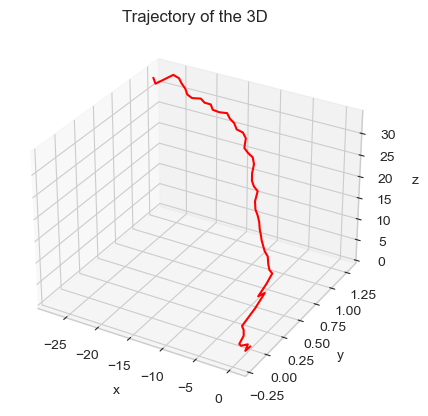

In [85]:
x, y, z = trajectory
fig = plt.figure()
ax = plt.axes(projection='3d')

# set figure information
ax.set_title('Trajectory of the 3D')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

# draw the figure, the color is r = read
figure = ax.plot(x, y, z, c='r')

plt.show()
